In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bruges import filters

###  Modelo convolucional 

Sabe-se que o modelo convolucional é descrito pela seguinte Equação:

$$p_t = W * Rc + \textit{noise}$$

em que:

   W - É a wavelet;
    
   Rc - É a função refletividade; e
    
   <i> noise </i> - ruído desconhecido
   
A seguir será explicado como o traço sísmico é gerado através de um modelo sintético, sem levar em consideração o fenômeno de absorção de energia nem a presença de ruídos.

### Criando um modelo geológico

In [2]:
z = np.arange(100,700,0.1) #Vetor da profundidade de 100 - 550m
v = np.zeros(len(z))       #Criando um vetor nulo que será armazenado a velocidade
d = np.zeros(len(z))       #Criando um vetor nulo que será armazenado a densidade

In [3]:
#Criando um modelo geologico de camadas
for i in range(0,len(z)):
    if z[i]<=220:
        v[i]=1900 ; d[i]=2.55
    if z[i]>220 and z[i]<=310: 
        v[i]=2500 ; d[i]=2.55
    if z[i]>310 and z[i]<=370: 
        v[i]=2000 ; d[i]=2.4
    if z[i]>370 and z[i]<=390: 
        v[i]=3000 ; d[i]=2.65
    if z[i]>390 and z[i]<=470: 
        v[i]=2500 ; d[i]=2.55
    if z[i]>470 and z[i]<=510: 
        v[i]=3000 ; d[i]=2.65
    if z[i]>510 and z[i]<=590: 
        v[i]=2500 ; d[i] = 2.4
    if z[i]>590: 
        v[i]=4500 ; d[i]=2.75

In [4]:
#Criando um DataFrame
df = pd.DataFrame({'Depth':z,'Vp':v,'Rho':d*1000}) #multiplicando densidade por 1000 (SI)
df.head()

,Depth,Vp,Rho
0,100.0,1900.0,2550.0
1,100.1,1900.0,2550.0
2,100.2,1900.0,2550.0
3,100.3,1900.0,2550.0
4,100.4,1900.0,2550.0


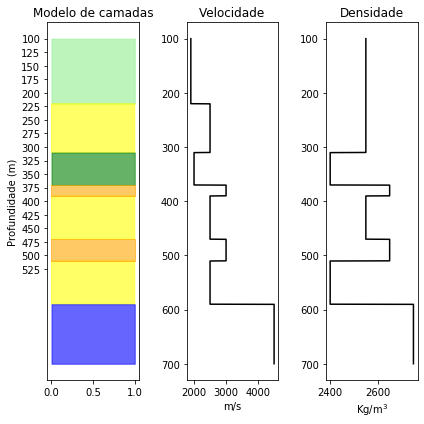

In [5]:
#Plotando o modelo geológico, velocidade e densidade
fig,axes = plt.subplots(ncols=3,figsize=(6,6))

for ax in axes:
    ax.invert_yaxis()

color = ['lightgreen','yellow','green','orange','blue']
for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.Depth,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)
    
axes[0].set_ylabel('Profundidade (m)')
axes[0].set_title('Modelo de camadas')
axes[0].set_yticks(np.arange(100,550,25))

axes[1].plot(df.Vp,df.Depth,color='black')
axes[1].set_title('Velocidade')

axes[1].set_xlabel('m/s')
axes[2].plot(df.Rho,df.Depth,color='black')
axes[2].set_xlabel('Kg/m$^3$')
axes[2].set_title('Densidade')

fig.tight_layout()

Antes de calcular o coeficiente de reflexão, precisamos definir  impedância acústica. A <b>impedância acústica</b> ($AI$) é definida em função da velocidade ($v$) e da densidade ($\rho$), e em geral, quanto maior a impedância acústica, "mais rigida" é a rocha (<a href="https://www.geologiabr.com/livros/geofisica-de-exploracao"> Kearey et.al, 2009 </a>):

$$ AI = v \cdot \rho $$

O <b> coeficiente de reflexão </b> ($R_c$) é um efeito numérico da interface sobre a propagação de onda, e tem a ver com as proporções relativas de energia transmitida e refletida. Para um raio que incide normalmente (ângulo de 90°) sobre uma camada, pode ser definido como:

### <center> </center>

$$ R_c = \frac{V_{2}\cdot\rho_{2}-V_{1} \cdot \rho_{1}}{V_{2}\cdot\rho_{2}+V_{1} \cdot \rho_{1}} = \frac{AI_2-AI_1}{AI_2+AI_1} $$

In [6]:
df['AI'] = df['Vp']*df['Rho'] #Calculando a impedância acústica
df.head()

,Depth,Vp,Rho,AI
0,100.0,1900.0,2550.0,4845000.0
1,100.1,1900.0,2550.0,4845000.0
2,100.2,1900.0,2550.0,4845000.0
3,100.3,1900.0,2550.0,4845000.0
4,100.4,1900.0,2550.0,4845000.0


In [7]:
#Calculando o coeficiente de reflexão
Rc = np.zeros(len(df['AI']))
for i in range(0,len(df['AI'])-1):
    Rc[i] = (df['AI'][i+1]-df['AI'][i])/(df['AI'][i+1]+df['AI'][i])
df['Rc'] = Rc
df.head()

,Depth,Vp,Rho,AI,Rc
0,100.0,1900.0,2550.0,4845000.0,0.0
1,100.1,1900.0,2550.0,4845000.0,0.0
2,100.2,1900.0,2550.0,4845000.0,0.0
3,100.3,1900.0,2550.0,4845000.0,0.0
4,100.4,1900.0,2550.0,4845000.0,0.0


Devemos lembrar que no modelo convolucional do traço sísmico temos a representação de interação da onda acústica com uma camada, que é registrada como o tempo duplo (<i>Two way travel time</i>) que a onda percorre da superfície até refletir em uma camada e retornar a superfície para ser registrada por um receptor.

Para estimar o templo duplo (TWT), temos que fazer a soma cumulativa da vagarosidade registrada em poço.

A vagarosidade é o inverso da velocidade acústica:

$$ \Delta t = \frac{1}{v}. $$

Comumente é apresentada em pés por segundo (pé/s), porém sua unidade no SI é dado em metros por segundo (m/s).

In [8]:
#Consideremos a velocidade média dos 100 primeiros metros 1700
df['Dt_SI'] = 1/df['Vp'] #Obtendo a vagarosidade no SI
df['TWT']=(2*100/1700) + 2*(df['Depth'][1]-df['Depth'][0])*np.cumsum(df['Dt_SI']) #Calculando o Two-way-travel time
df.head()

,Depth,Vp,Rho,AI,Rc,Dt_SI,TWT
0,100.0,1900.0,2550.0,4845000.0,0.0,0.000526,0.117752
1,100.1,1900.0,2550.0,4845000.0,0.0,0.000526,0.117858
2,100.2,1900.0,2550.0,4845000.0,0.0,0.000526,0.117963
3,100.3,1900.0,2550.0,4845000.0,0.0,0.000526,0.118068
4,100.4,1900.0,2550.0,4845000.0,0.0,0.000526,0.118173


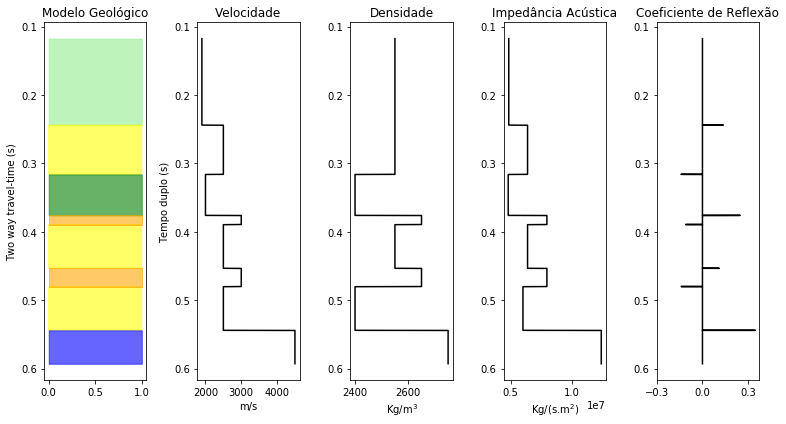

In [9]:
#Plotando modelo e o coeficiente de reflexão
fig,axes = plt.subplots(ncols=5,figsize=(11,6))

for ax in axes:
    ax.invert_yaxis()

for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.TWT,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)
    
axes[0].set_title('Modelo Geológico')
axes[0].set_ylabel('Two way travel-time (s)')
    
axes[1].plot(df.Vp,df.TWT,color='black')
axes[1].set_title('Velocidade')
axes[1].set_xlabel('m/s')
axes[1].set_ylabel('Tempo duplo (s)')

axes[2].plot(df.Rho,df.TWT,color='black')
axes[2].set_title('Densidade')
axes[2].set_xlabel('Kg/m$^3$')

axes[3].plot(df.AI,df.TWT,color='black')
axes[3].set_title('Impedância Acústica')
axes[3].set_xlabel('Kg/(s.m$^2$)')

axes[4].plot(df.Rc,df.TWT,color='black')
axes[4].set_title('Coeficiente de Reflexão')
axes[4].set_xticks(np.arange(-0.3,0.3+0.3,0.3))

fig.tight_layout()

### Reamostrando o dado

Vamos criar um traço sintético com taxa de amostragem igual a $\Delta t = 2ms$. Para isso, teremos que reamostrar o nosso dado sintético.

In [10]:
#Reamostrando a impedância acústica para uma taxa de amostragem de 2ms
dt = 0.002
t = np.arange(0,df.TWT.max()+dt,dt)
Vp = np.interp(x=t,xp=df['TWT'],fp=df['Vp'])
AI = np.interp(x=t,xp=df['TWT'],fp=df['AI'])

In [11]:
#Calculando o coeficiente de reflexão
Rc = np.zeros(len(AI))
for i in range(0,len(Rc)-1):
    Rc[i] = (AI[i+1]-AI[i])/ (AI[i+1]+AI[i])

In [12]:
#Criando um DataFrame com as informações anteriores
trace = pd.DataFrame({'Time':t,
                      'Vp':Vp,
                     'AI':AI,
                     'Rc':Rc})
trace.head()

,Time,Vp,AI,Rc
0,0.000,1900.0,4845000.0,0.0
1,0.002,1900.0,4845000.0,0.0
2,0.004,1900.0,4845000.0,0.0
3,0.006,1900.0,4845000.0,0.0
4,0.008,1900.0,4845000.0,0.0


### Criando uma wavelet de fase zero

É importante lembrar que fontes reais como <i>vibroseis</i> e <i>airguns</i> produzem assinaturas de fase minima. A wavelet de fase minima é aquela que não tem nenhuma energia registrada antes do tempo zero.

Para efeitos didáticos, será criada uma wavelet de fase zero, aquela cujo o pico de amplitude está centrada em zero e com polaridade positiva (padrão americano).

A wavelet utilizada será a ricker, que é definida como:

$$ A(t) = (1-2\pi^2f_M^2t^2)e^{-\pi^2f_M^2t^2} $$

In [13]:
#Criando uma wavelet ricker utilizando o pacote bruges
#frequência de 25Hz, taxa de amostragem de 2ms e  tempo de duração de 128ms
wave_ricker,t_wave = filters.wavelets.ricker(0.128,dt=0.002,f=25,return_t=True)

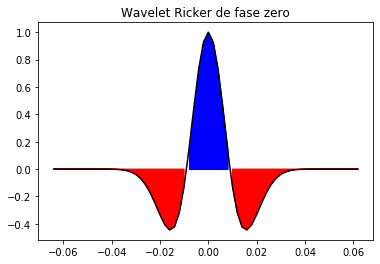

In [14]:
plt.title('Wavelet Ricker de fase zero')
plt.plot(t_wave,wave_ricker,color='black')
plt.fill_between(x=t_wave,y1=wave_ricker,y2=0,where=(wave_ricker>0),color='blue')
plt.fill_between(x=t_wave,y1=wave_ricker,y2=0,where=(wave_ricker<0),color='red')

Convolvendo o a wavelet com a função refletividade para gerar o modelo do traço sísmico (sem ruído):

$$p_t = W * Rc$$

In [15]:
trace['t_synth_1'] = np.convolve(wave_ricker,trace.Rc,mode='same')

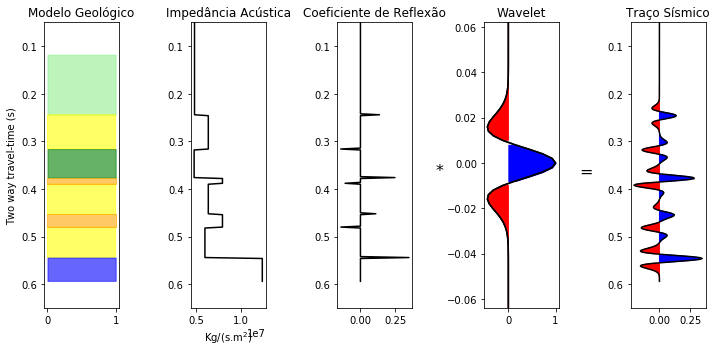

In [18]:
#Plotando o traço sísmico

fig,axes = plt.subplots(ncols=5,figsize=(10,5))

for ax in axes:
    ax.set_ylim(0.05,0.65)
    ax.invert_yaxis()


for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.TWT,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)
    
axes[0].set_title('Modelo Geológico')
axes[0].set_ylabel('Two way travel-time (s)')

axes[1].plot(trace.AI,trace.Time,color='black')
axes[1].set_title('Impedância Acústica')
axes[1].set_xlabel('Kg/(s.m$^2$)')

axes[2].plot(trace.Rc,trace.Time,color='black')
axes[2].set_title('Coeficiente de Reflexão')

axes[3].plot(wave_ricker,t_wave,color='black')
axes[3].fill_betweenx(y=t_wave,
                     x1=wave_ricker,
                     x2=0,
                     where=wave_ricker>0,color='blue')

axes[3].plot(wave_ricker,t_wave,color='black')
axes[3].fill_betweenx(y=t_wave,
                     x1=wave_ricker,
                     x2=0,
                     where=wave_ricker<0,color='red')

axes[3].set_ylim(t_wave.min(),t_wave.max())

axes[3].set_title('Wavelet')

axes[4].plot(trace.t_synth_1,trace.Time,color='black')
axes[4].fill_betweenx(y=trace.Time,
                 x1=trace.t_synth_1,
                 x2=0,
                 where=trace.t_synth_1>0,color='blue')

axes[4].fill_betweenx(y=trace.Time,
                 x1=trace.t_synth_1,
                 x2=0,
                 where=trace.t_synth_1<0,color='red')

axes[4].set_title('Traço Sísmico')

fig.text(x=0.61,y=0.5,s='*',fontsize=16)

fig.text(x=0.81,y=0.5,s='=',fontsize=16)

fig.tight_layout()

In [17]:
trace.to_csv('Dados/traco_sintetico.csv',index=False)